# LINEAR REGRESSION FROM SCRATCH

In [1]:
#######################################################
##### SINGLE VARIABLE LINEAR REGRESSION ALGORITHM #####
############################### -Siddharth Yadav- #####

####==== linear_regression_from_scratch.ipynb =====####
# Contains the source code for the linear regression algorithm

# Importing the necessary libraries
import random
import numpy as np
import matplotlib.pyplot as plt


# Defining a linear regression algorithm class
class LinearRegressionAlgorithm:
    '''A class for initializing and training a single-variable linear regression model
    
    Parameters
    **********
    
    all_features : List of numbers (integers/floats) - 1D array
                   The features of the data corresponsding to the x-variable (independent)
    
    all_labels   : List of numbers (integers/floats) - 1D array
                   The labels of the data corresponding to the y-variable (dependent)
    
    *
    
    learning_rate : Float (default=0.01)
                    The magnitude by which the model parameters are updated.
                    Low values  (<0.01) result in slower convergence
                    High values (>0.1)  may fail to converge
    
    epochs        : Integer (default=100)
                    The number of training cycles
    
    strict_reduce : Boolean (default=False)
                    False : The model is updated even if it does not reduce the current total loss
                    True  : The model only updates if the total loss reduces (may lead to stagnation during training)
    
    batch size    : Integer (default=1) (range: 1 -> number of x-variables) 
                    The number of points to consider for updating the model per training cycle.
                    1        : stochastic descent
                    >1       : mini-batch descent
                    maximum  : batch descent (maximum=number of x-varaibles)
    '''
    
    # Initializing the algorithm with the features, labels and hyperparameters
    def __init__(self, all_features, all_labels, *, learning_rate=0.001, epochs=100, strict_reduce=False, batch_size=1):
        # Checking if features and labels show 1-on-1 correspondence
        if len(all_features) != len(all_labels):
            raise ValueError(f"The number of features (n={len(all_features)}) and labels (n={len(all_labels)}) should be equal")
        
        self.all_features = all_features # The features of the dataset
        self.all_labels = all_labels # The associated labels of the dataset
        self.learning_rate = learning_rate # The learning rate controls the magnitude by which the model parameters updates
        self.epochs = epochs # The number of training cycles
        self.strict_reduce = strict_reduce # If True, the model is updated only if the total error is reduced
        self.batch_size = batch_size # The number of points to consider for updating model per training cycle (default=1: i.e., stochastic descent)
        
        self.model = (np.random.random(), np.random.random()) # Initializing the model with a random weight and bias
        self.errors = [self.total_rmse_error()] # List to store total error per training cycle
        
        
    # Returns random data points from the dataset
    def select_random_points(self):
        return random.sample(list(zip(self.all_features, self.all_labels)), k=self.batch_size)
    
    
    # Returns the prediction of the current model for the provided data point (optionally, a custom model can be provided)
    def prediction(self, data_point, *, _manual_model=None):
        if _manual_model is not None: # Setting the weight and bias from the custom model
            weight, bias = _manual_model
        else: # Setting the weight and bias from the current model
            weight, bias = self.model
            
        return weight * data_point[0] + bias # Calculating the prediction (label)
    
    
    # Returns the updated value for the weight and bias
    def update_parameters(self, data_point):
        weight, bias = self.model # Setting the weight and bias from the current model

        pred = self.prediction(data_point) # The current prediction
        error = data_point[1] - pred # The calculated error
        
        new_weight = weight + self.learning_rate*error*np.copysign(1,data_point[0]) # Updated weight
        new_bias = bias + self.learning_rate*error # Updated bias
        
        # Calculating the total error for the updated parameters
        current_error = self.total_rmse_error(_manual_model=(new_weight, new_bias))
        
        # Updating the best model if the total error is reduced
        if current_error <= self.errors[-1]:
            self.best_model = new_weight, new_bias 
        
        # If strict_reduce is True 
        if self.strict_reduce:
            if current_error <= self.errors[-1]: 
                return new_weight, new_bias # Returning the updated parameters if they reduce the total error        
            else:
                return weight, bias # Retaining the current parameter if the total error does not reduce

        # Returning the updates parameters
        return new_weight, new_bias
    
    
    # Calculating the total rmse (root mean squared) error for the current model on the entire dataset (optionally, a custom model can be provided)
    def total_rmse_error(self, *, _manual_model=None):
        if _manual_model is not None: # Calculating squared errors for the custom model (if provided)
            squared_errors = [(point[1] - self.prediction(point, _manual_model=_manual_model))**2 for point in zip(self.all_features, self.all_labels)]
        else: # Calculating squared errors for the current model
            squared_errors = [(point[1] - self.prediction(point))**2 for point in zip(self.all_features, self.all_labels)]
        
        rmse = np.sqrt(np.sum(squared_errors)) # Calculating the rmse and returning it
        return rmse

    
    # Updating the model for the specified number of epochs (training cycles)
    def train(self):
        '''Trains the model for the specified number of epochs (training cycles)'''
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}", end='\r', flush=False) # Pritintg the current epoch
            
            random_points = self.select_random_points() # Selecting a batch of random data points
            for point in random_points: # Iterating over the batch
                self.model = self.update_parameters(point) # Updating the model
        
            self.errors.append(self.total_rmse_error()) # Appending the total error to the errors list
        
        # Printing the final model error and accuracy (compared to numpy's polyfit model) 
        lowest_error = self.total_rmse_error(_manual_model=np.polyfit(self.all_features, self.all_labels, 1))
        print(f"\nLowest model error: {self.total_rmse_error(_manual_model=self.best_model):.3f}\nLowest theoretical error: {lowest_error:.3f}")
        
        
    # Plotting the training results
    def plot_results(self): 
        '''Plot the training results.
        
        Two plots are generated:
            Scatterplot of the data with the best regression line and numpy polyfit line
            The total error (RMSE) per epoch'''
        
        def pred(w,b,f): # Defining a simple prediction calculation function
            return w*f + b
        
        # Getting the numpy polyfit model and developing points for plotting
        np_weight, np_bias = np.polyfit(self.all_features, self.all_labels, 1)
        plot_xs = np.linspace(min(self.all_features)-10, max(features)+10, 100)
        plot_ys = [pred(self.best_model[0], self.best_model[1], x) for x in plot_xs]
        numpy_ys = [pred(np_weight, np_bias, x) for x in plot_xs]

        # Setting up the style and figure parameters
        plt.style.use('seaborn-darkgrid')
        fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=300)

        # Setting up the regression line subplot
        ax[0].scatter(self.all_features,self.all_labels,alpha=0.5, edgecolors='none', s=100)
        ax[0].plot(plot_xs, plot_ys, label='Best regression line', lw=3, alpha=0.8)
        ax[0].plot(plot_xs, numpy_ys, label="Numpy's polyfit line", lw=3, alpha=0.8)
        ax[0].set_xlabel("Feature x", fontsize=12)
        ax[0].set_ylabel("Feature y", fontsize=12)
        ax[0].set_xlim(min(self.all_features)-5, max(self.all_features)+5)
        ax[0].set_ylim(min(self.all_labels)-5, max(self.all_labels)+5)
        ax[0].set_title("Regression lines post training", fontsize=15, fontweight='bold', pad=20)
        ax[0].legend(frameon=True, facecolor='white', shadow=True, fontsize=12, loc=2)
        ax[0].tick_params(axis='both', which='major', labelsize=10)

        # Setting up the error subplot
        ax[1].plot(self.errors)
        ax[1].set_xlabel("Epochs", fontsize=12)
        ax[1].set_ylabel("RMSE", fontsize=12)
        ax[1].set_title("Root mean sqaured error (RMSE) during training", fontsize=15, fontweight='bold', pad=20)
        ax[1].axhline(np.mean(self.errors), color='gray', label=f'Average RMSE\n({np.mean(self.errors):.3f})', alpha=0.6, lw=3)
        ax[1].axhline(np.min(self.errors), color='green', label=f'Lowest RMSE\n({np.min(self.errors):.3f})', alpha=0.6, lw=3)
        ax[1].legend(frameon=True, facecolor='white', shadow=True, fontsize=12, loc=1)
        ax[1].tick_params(axis='both', which='major', labelsize=10)
        
        # Displaying the plot
        plt.tight_layout()
        plt.show()
        

## Generating a small dataset for training

In [6]:
# Generating a random dataset
dispersion_value = 40 # Adding random noise to the data
features = [np.random.randint(i-dispersion_value, i+dispersion_value) for i in range(200)] # x-values
labels = [np.random.randint(i-dispersion_value, i+dispersion_value) for i in range(200)] # y-values

## Setting up the linear regression model

Epoch 250/250
Lowest model error: 439.165
Lowest theoretical error: 429.581


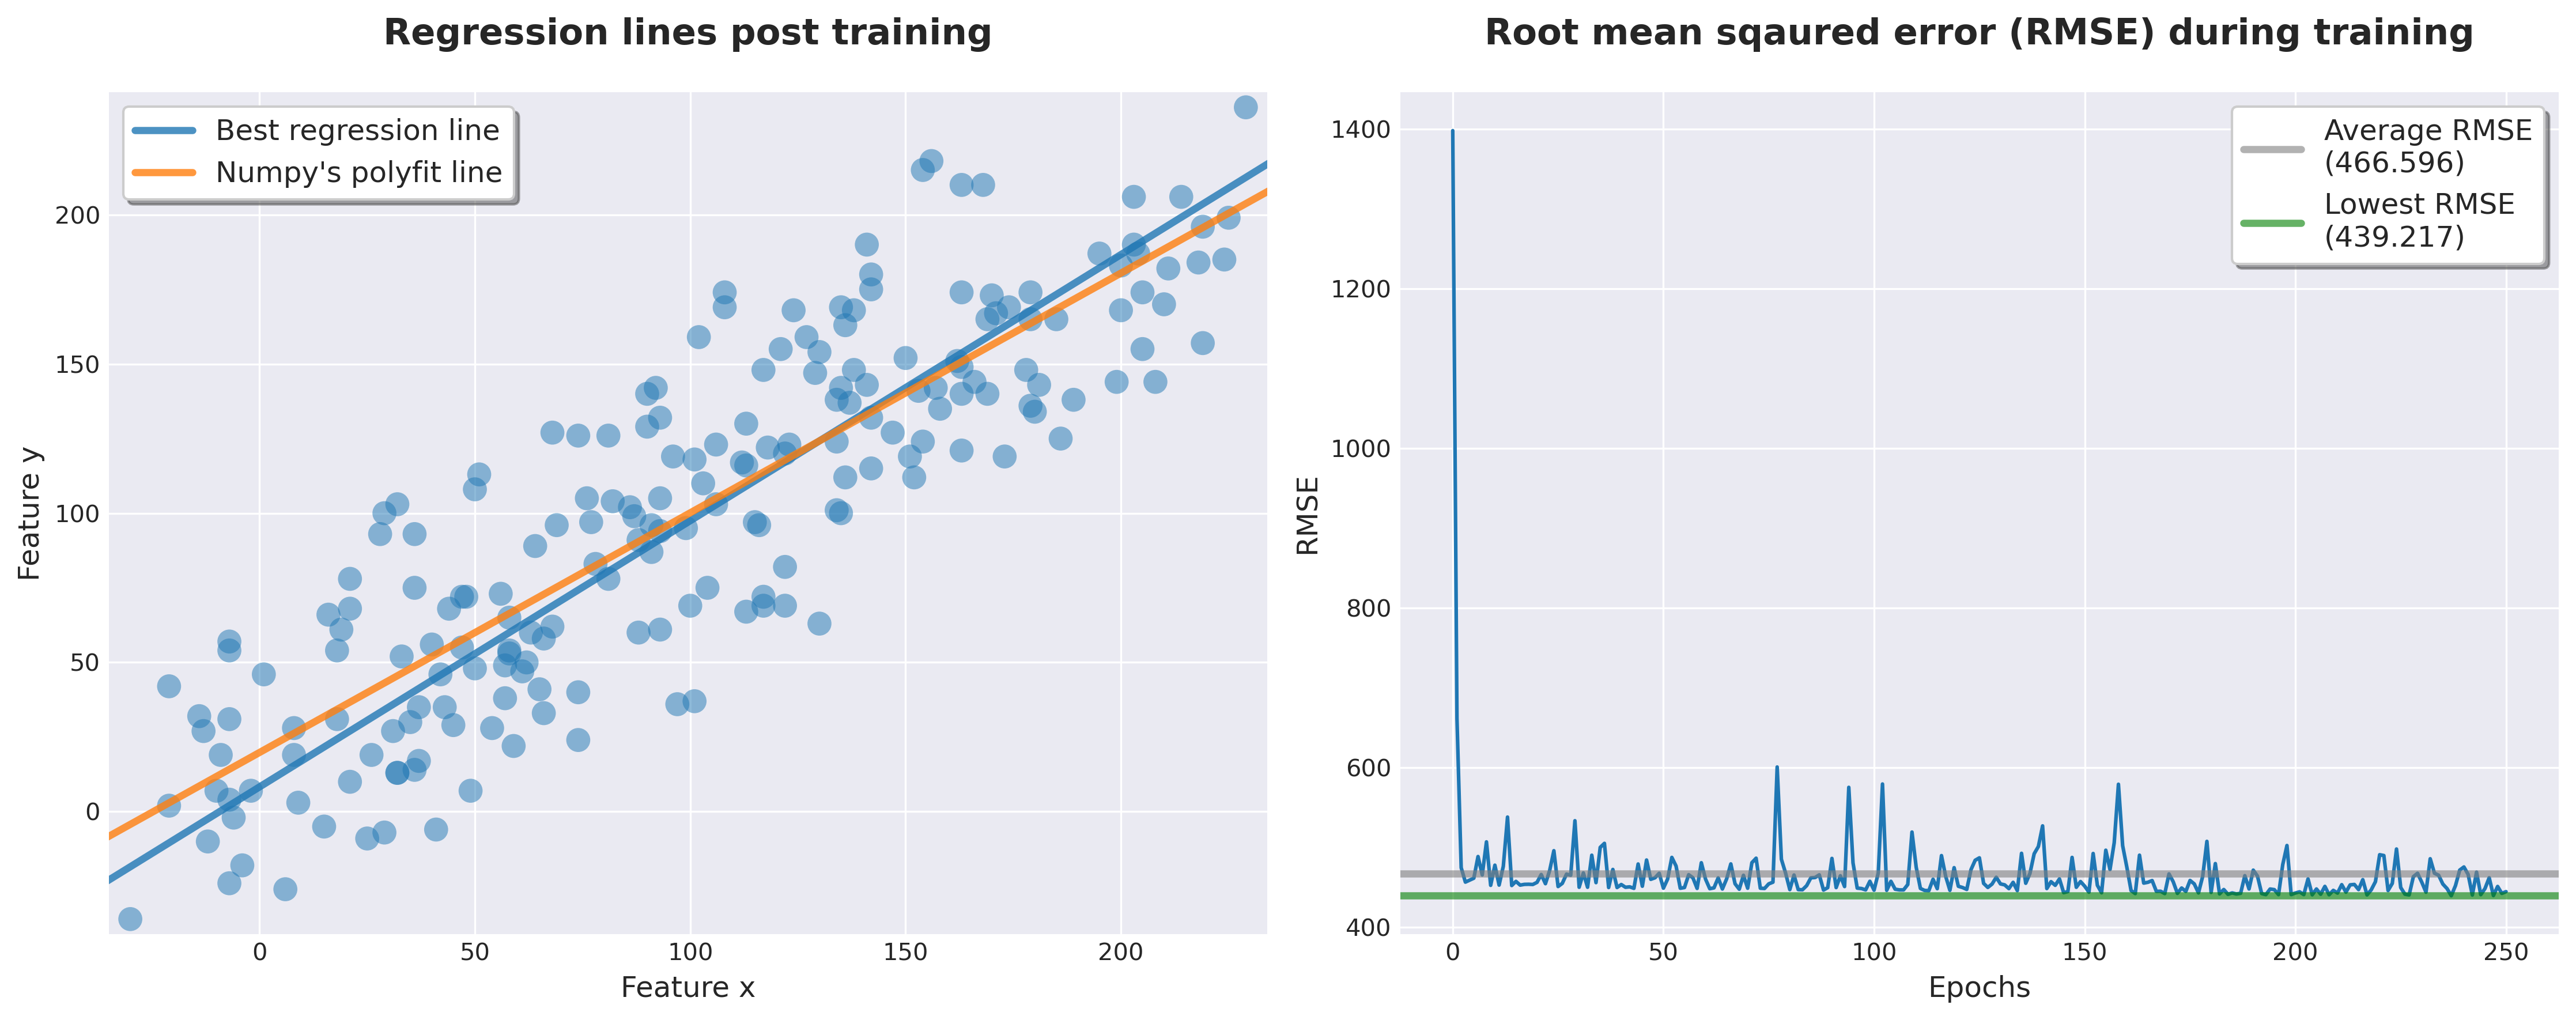

In [7]:
# Initializing the model with the generated dataset and appropriate hyperparameters
model = LinearRegressionAlgorithm(features, labels, learning_rate=0.001, epochs=250, strict_reduce=False, batch_size=10)
model.train()
model.plot_results()